# Prediction of sales of Superstore according to the products, regions, categories and customer segments
---
>
# For this problem we are going to use ***"Linear Regression"***
---
>
# Hypothesis
>
1) Average sales per month
>
2) Top demanded product
>
3) customers favourite shipping mode


Importing Ncessary Libraries

In [195]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from prettytable import PrettyTable
%matplotlib inline

#data transformation
from scipy import stats #this library is used for functions like mean etc.

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

#colors
colors = ['#F0D290','#DE834D','#A3423C','#781D42']
colors2 = ['#F0D290','#DE834D','#A3423C','#781D42','#671E31']
colors3 = ['#f0d290','#e9c083','#e2af77','#d99d6d','#d08c64', '#c67b5d', '#bc6b56','#b05a51','#a34b4d','#963b49', '#872c45','#781d42']

#xgboost
from xgboost import XGBRegressor

# Loading Data and Data Overview

In [196]:
data = pd.read_csv('/content/Superstore_data.csv', encoding= 'unicode_escape') #encoding = unicode_escape means to interpret the unicodes properly.
data.head(2) #show two rows of the data

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


In [197]:
#showing the all columns in dataframe
data.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [198]:
#we will get some statistics by describe() function
data.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [199]:
#info() function gives us the information about total rows, dtype etc
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [200]:
#changing date for mat form order and ship date
data['Ship Date'] = pd.to_datetime(data['Ship Date'],format='%m/%d/%Y')
data['Order Date'] = pd.to_datetime(data['Order Date'],format='%m/%d/%Y')

In [201]:
print('checking the changed datatype\n',data['Order Date'].dtype,data['Ship Date'].dtype)

checking the changed datatype
 datetime64[ns] datetime64[ns]


In [202]:
#make columns year-month for order and ship
data.insert(loc=3,  column='order_month_year',value=data['Order Date'].dt.to_period('M'))
data.insert(loc=8, column='ship_month_year', value=data['Ship Date'].dt.to_period('M'))

#make separate columns for day, month and year
data.insert(loc=4, column='order_day', value=data['Order Date'].dt.day)
data.insert(loc=5, column='order_month', value=data['Order Date'].dt.month)
data.insert(loc=6, column='order_year', value=data['Order Date'].dt.year)

#making same columns for the ship column
data.insert(loc=7, column='ship_day', value = data['Ship Date'].dt.day)
data.insert(loc=8, column='ship_month', value= data['Ship Date'].dt.month)
data.insert(loc=9, column='ship_year', value=data['Ship Date'].dt.year)

data.head(2)

,Row ID,Order ID,Order Date,order_month_year,order_day,order_month,order_year,ship_day,ship_month,ship_year,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11,8,11,2016,11,11,2016,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11,8,11,2016,11,11,2016,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


In [203]:
#the shape of the dataset is (rows x columns)
data.shape

(9994, 29)

In [204]:
#lets split the data manually
#70% train and 30% test
raw_train = data.iloc[:6995] #it will contain the all rows from 0 to 6995 and all columns
raw_test = data.iloc[6995:].drop(columns='Sales') #it will contains all the rows from 6995 to last row and all columns except Sale because it is our target variable

#lets copy this test and train into another variable so in any case data gone we will have backup
train_og = raw_train.copy()
test_og = raw_test.copy()


#  Exploratory Data Analysis

Lets drop all columns which are not relevent to our process

In [205]:
#first lets check all the columns
raw_test.columns

Index(['Row ID', 'Order ID', 'Order Date', 'order_month_year', 'order_day',
       'order_month', 'order_year', 'ship_day', 'ship_month', 'ship_year',
       'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name',
       'ship_month_year', 'Segment', 'Country', 'City', 'State', 'Postal Code',
       'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name',
       'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [206]:
raw_test.drop(columns=['Row ID','Order ID', 'Customer ID', 'Customer Name', 'Product ID', 'Product Name'], inplace=True)
raw_train.drop(columns=['Row ID','Order ID', 'Customer ID', 'Customer Name', 'Product ID', 'Product Name'], inplace=True)
raw_train.columns

Index(['Order Date', 'order_month_year', 'order_day', 'order_month',
       'order_year', 'ship_day', 'ship_month', 'ship_year', 'Ship Date',
       'Ship Mode', 'ship_month_year', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Category', 'Sub-Category', 'Sales',
       'Quantity', 'Discount', 'Profit'],
      dtype='object')

#Checking for Duplicates

In [207]:
raw_train.duplicated().value_counts() #whether the values of two rows are similar or not

,count
False,6994
True,1


In [208]:
raw_test.duplicated().value_counts()

,count
False,2999


In [209]:
raw_train.drop_duplicates(inplace=True)
raw_train.duplicated().value_counts()

,count
False,6994


# Univariate Analysis


**Categorical Features**

Text(0.5, 1.0, 'Number of items per Region')

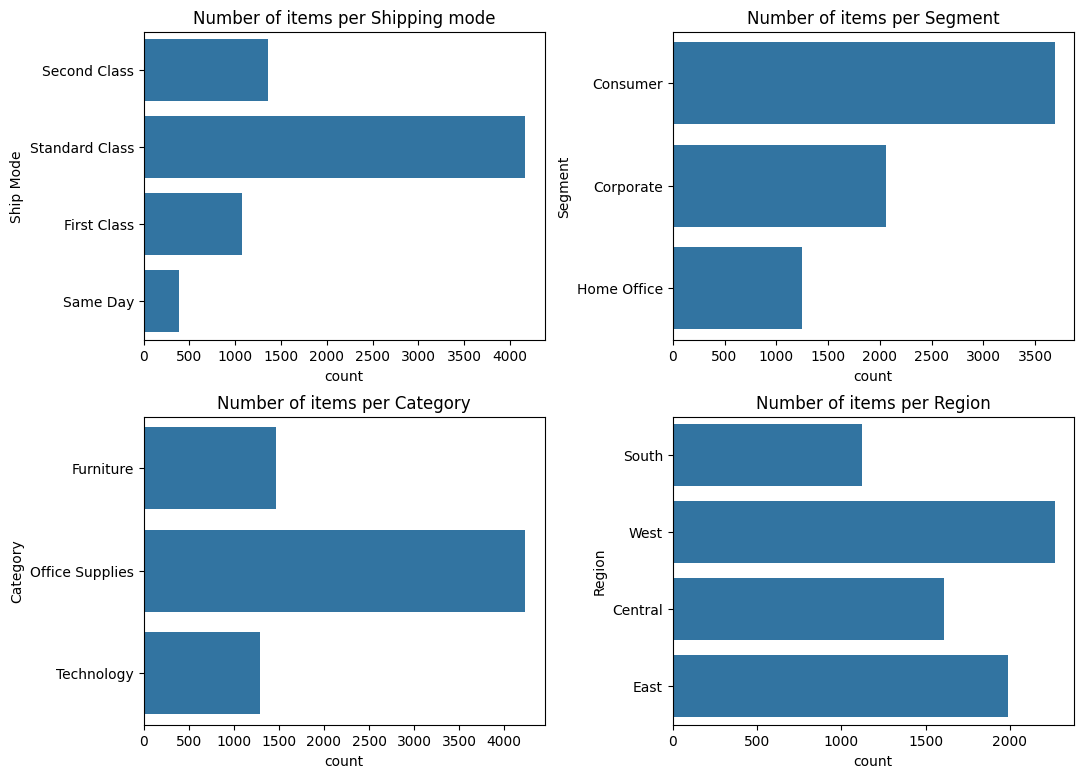

In [210]:
#determining plotting ID and width and height
#if no ID previously given then it will create newone else take last one
plt.figure(1, figsize=(12, 9))
#determining the width and hight bw all plots
plt.subplots_adjust(wspace = 0.32, hspace = 0.25)

plt.subplot(221)
sns.countplot(data=raw_train, y='Ship Mode',orient='h');
plt.title("Number of items per Shipping mode");
plt.subplot(222)
sns.countplot(data=raw_train, y='Segment',orient='h');
plt.title('Number of items per Segment');
plt.subplot(223)
sns.countplot(data=raw_train, y='Category',orient='h');
plt.title('Number of items per Category');
plt.subplot(224)
sns.countplot(data=raw_train, y='Region',orient='h');
plt.title('Number of items per Region')


from the above we can deduce that
>
Around 60% of the shipment happens in 'Standard Class' mode.
>
Consumer' segment makes up for around 50% of dataset
>
60% of the items are 'Office Supplies'
>
Majority of the items in dataset are from the 'West' region

**Numerical Features**

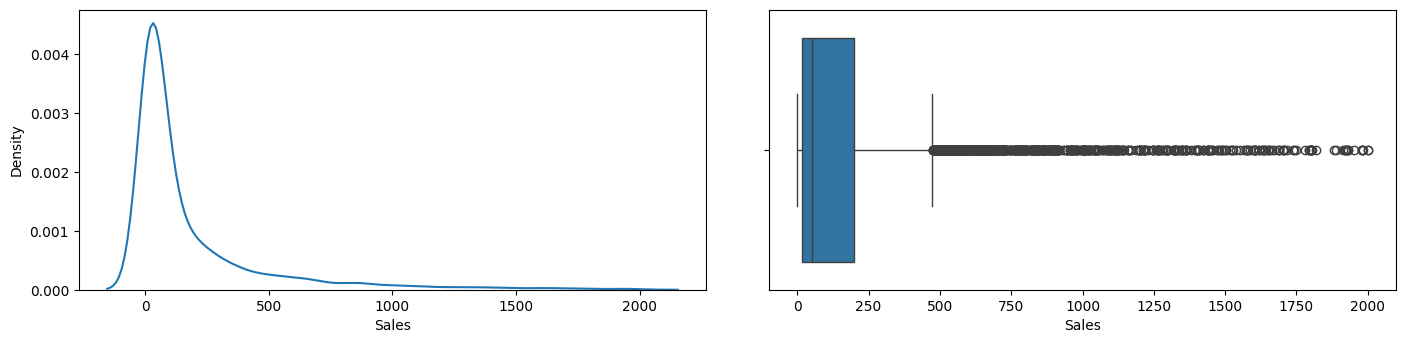

In [211]:
plt.figure(2, figsize=(17, 8))
plt.subplots_adjust(wspace=0.1);
#raw_train['Sales'] <= 2000] --> Fixing the Outliers (It is okay if you do not understand this)
#I am doing this so that we can see the visuals better. Do not do this randomly!
plt.subplot(221)
sns.kdeplot(data=raw_train[raw_train['Sales'] <= 2000], x='Sales');
plt.subplot(222)
sns.boxplot(data=raw_train[raw_train['Sales'] <= 2000], x='Sales',orient='h');


It can be inferred that most of the data in the distribution of Sales is towards left which means it is not normally distributed. The boxplot shows the pressence of outliers.

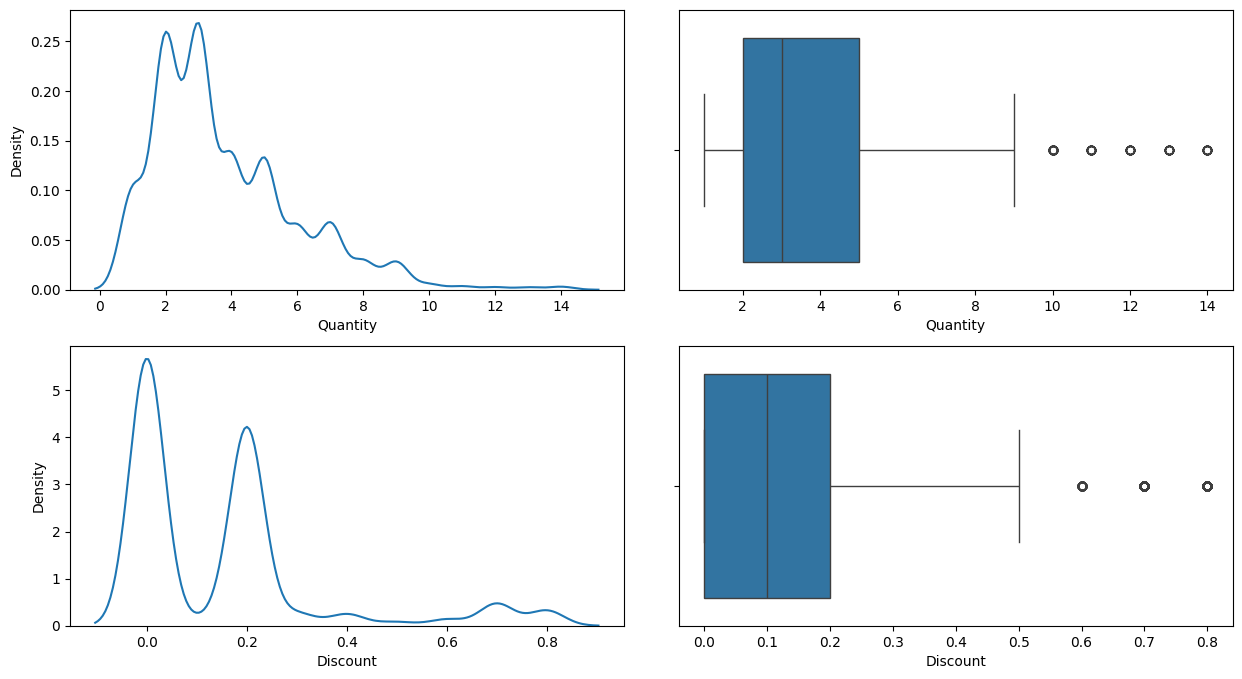

In [212]:
plt.figure(3, figsize=(15,8));
plt.subplots_adjust(wspace=0.1);

plt.subplot(221)
sns.kdeplot(data=raw_train, x='Quantity');

plt.subplot(222)
sns.boxplot(data=raw_train, x='Quantity');

plt.subplot(223)
sns.kdeplot(data=raw_train, x='Discount');

plt.subplot(224)
sns.boxplot(data=raw_train, x='Discount');

From histplots:
>
Most of the population from the dataset has bought 3 items.
>
20% discount rate is most common
>
From boxplots:
>
Boxplot on 'Quantity' shows that item purchase of more than 9 is very rare, and there are 5 such outliers
>
Discount rates of 60, 70, 80 are rare.

<Axes: xlabel='Profit'>

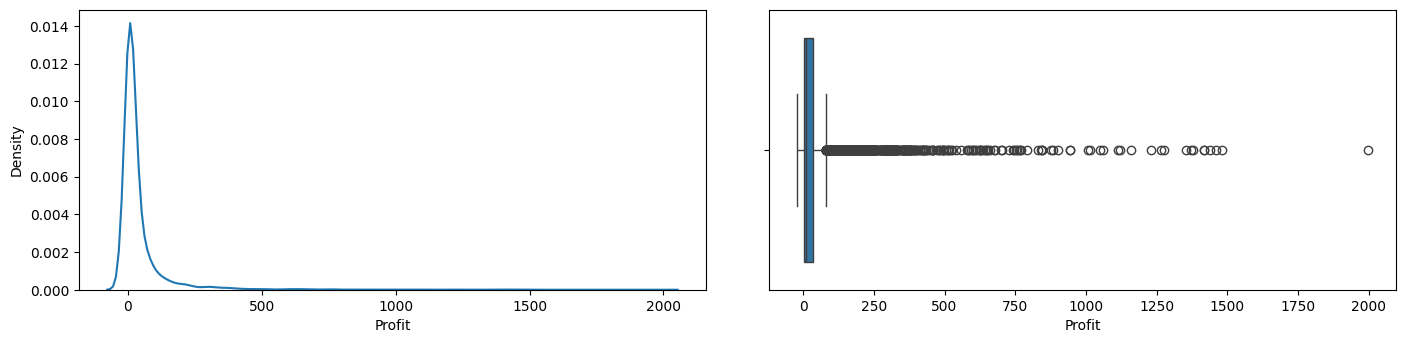

In [213]:
#profit
plt.figure(4, figsize=(17,8))
plt.subplots_adjust(wspace=0.1)

plt.subplot(221)
sns.kdeplot(data=raw_train[(raw_train.Profit <=2000)&(raw_train.Profit>=-20)], x='Profit')

plt.subplot(222)
sns.boxplot(data=raw_train[(raw_train.Profit <=2000)&(raw_train.Profit>=-20)], x='Profit')

#Bivariate Analysis


we will find out the answers of the following questions

* What is the average sales per month for the month?
* What is the top demanded product in United States?
* What is the favourite shipping mode for customers?



In [214]:
#finding avg salary
raw_train.columns

Index(['Order Date', 'order_month_year', 'order_day', 'order_month',
       'order_year', 'ship_day', 'ship_month', 'ship_year', 'Ship Date',
       'Ship Mode', 'ship_month_year', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Category', 'Sub-Category', 'Sales',
       'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [215]:
monthly_sales = pd.DataFrame(raw_train.groupby('order_month_year')[['Quantity','Sales']].sum()).reset_index() #it will sum the all values for each unique value of the order_month_year
monthly_sales.head(3)

,order_month_year,Quantity,Sales
0,2014-01,219,9413.681
1,2014-02,91,2979.008
2,2014-03,331,37498.440


**What is the average sales/month for the store?**

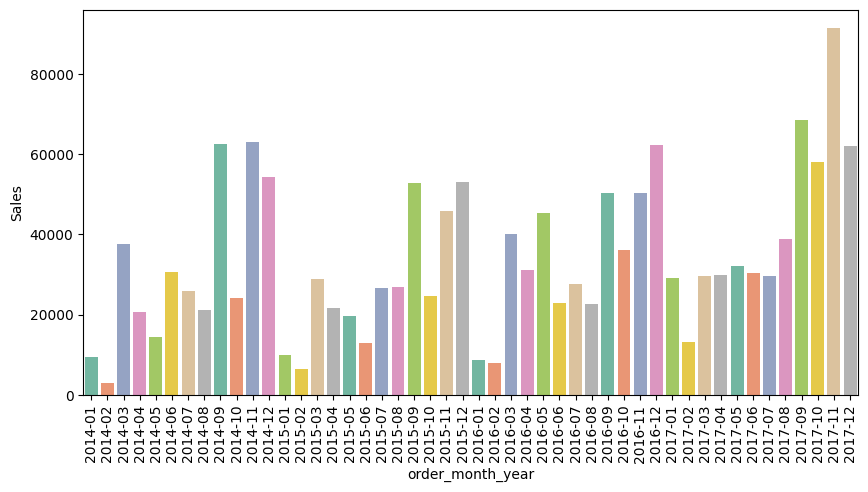

In [216]:
plt.figure(figsize=(10, 5)) #width and height
sns.barplot(x='order_month_year', y='Sales', data=monthly_sales,palette='Set2')
plt.xticks(rotation=90)
plt.show()

 **What is the top demanded product**

In [217]:
#top demanded product by category from data
most_demand_qty = pd.DataFrame(raw_train.groupby('Category')['Quantity'].sum().reset_index())
most_demand_qty.sort_values(by= 'Quantity', ascending=False, inplace=True)

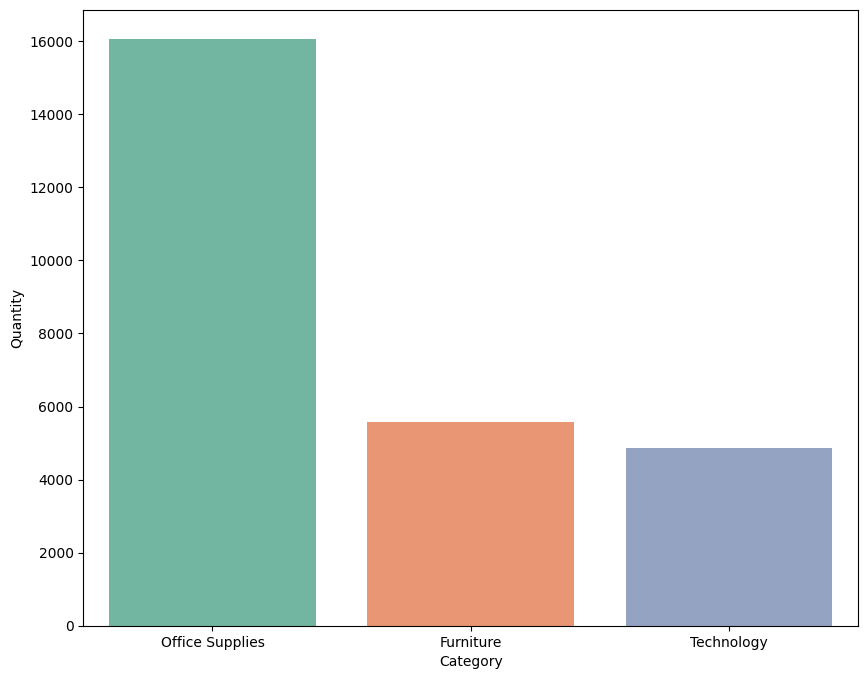

In [218]:
plt.figure(figsize=(10,8)) #width x height
sns.barplot(data=most_demand_qty, x='Category', y='Quantity', palette='Set2')
plt.show()

**What is the favourite shipping mode for customers?**

<Axes: >

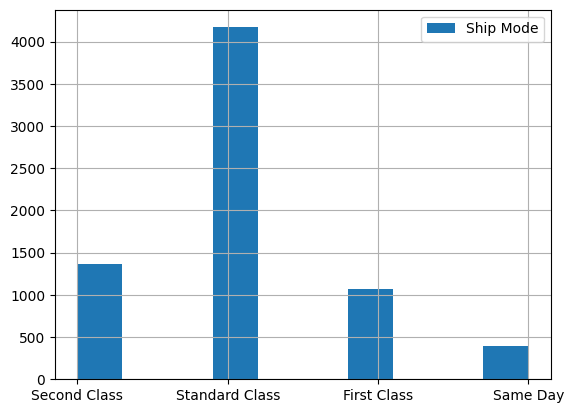

In [219]:
raw_train['Ship Mode'].hist(legend=True)

#Time Series Analysis

**What are the Number of Sales/Category, Number of Sales/Mode of shipment, Number of Sales/Mode of shipment repectively?**

In [220]:
regions = raw_train['Region'].unique()
shipmodes = raw_train['Ship Mode'].unique()
categories = raw_train['Category'].unique()

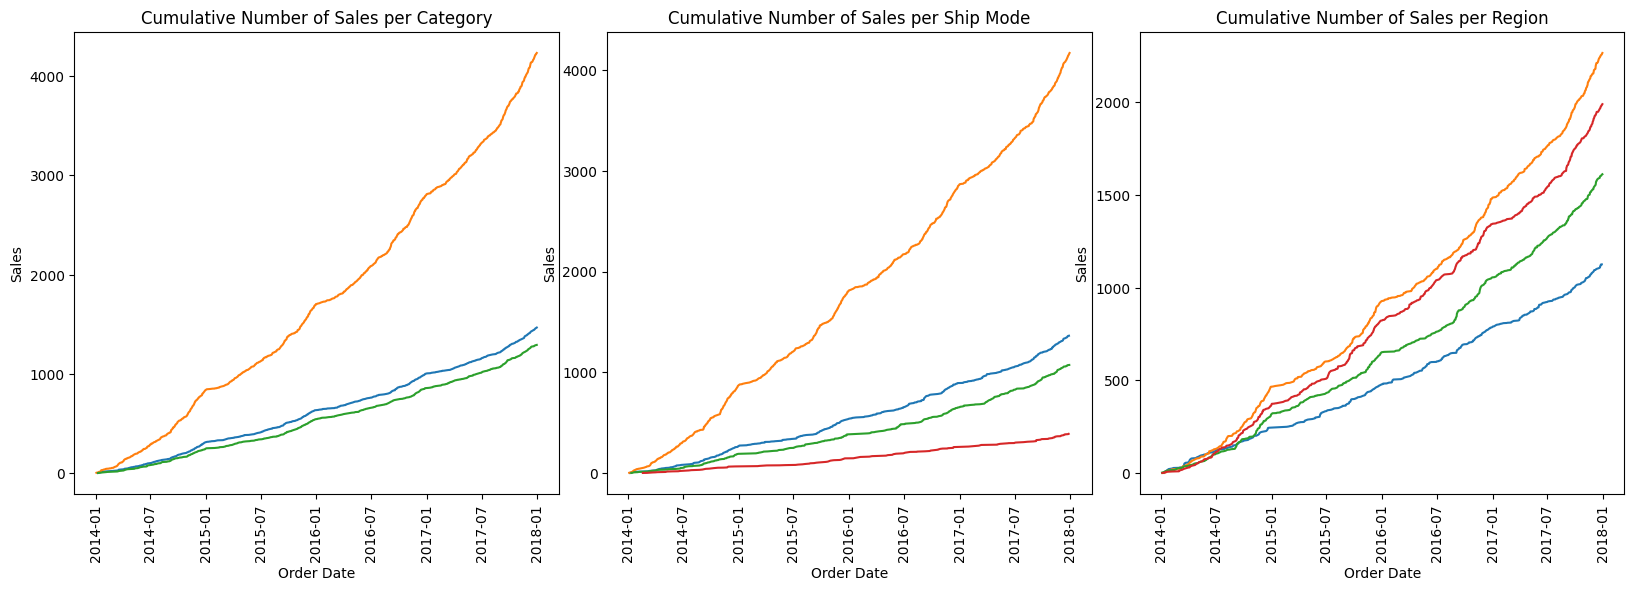

In [221]:
plt.figure(5, figsize=(20, 6))
plt.subplots_adjust(wspace=0.1)

dfbyCatOrderDate = raw_train.groupby(['Category', 'Order Date'])
plt.subplot(131).title.set_text('Cumulative Number of Sales per Category')
plt.xticks(rotation=90)

for cat in categories:
  dt = dfbyCatOrderDate['Sales'].count()[cat]
  dt = dt.cumsum()
  sns.lineplot(data=dt, ax=plt.subplot(131))

dfbyShipOrderDate = raw_train.groupby(['Ship Mode','Order Date'])
plt.subplot(132).title.set_text('Cumulative Number of Sales per Ship Mode')
plt.xticks(rotation=90)
for shipMode in shipmodes:
    data = dfbyShipOrderDate['Sales'].count()[shipMode]
    data = data.cumsum()
    sns.lineplot(data=data, ax=plt.subplot(132))

#graphing 'Sales' vs. 'Region'
dfbyRegionOrderDate = raw_train.groupby(['Region','Order Date'])
plt.subplot(133).title.set_text('Cumulative Number of Sales per Region')
plt.xticks(rotation=90)
for region in regions:
    data = dfbyRegionOrderDate['Sales'].count()[region]
    data = data.cumsum()
    sns.lineplot(data=data, ax=plt.subplot(133))

**What are the Sales for each Region?**

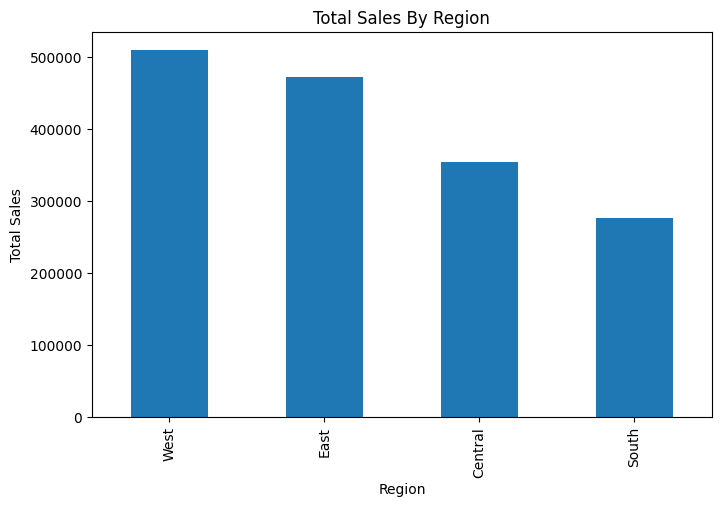

In [222]:
plt.figure(7, figsize=(8,5))
dfByRegion = raw_train.groupby('Region')
dfByRegion['Sales'].sum().sort_values(ascending=False).plot(kind='bar')
plt.ylabel('Total Sales');
plt.title('Total Sales By Region');

**Which Region is Profitable to the superstore?**

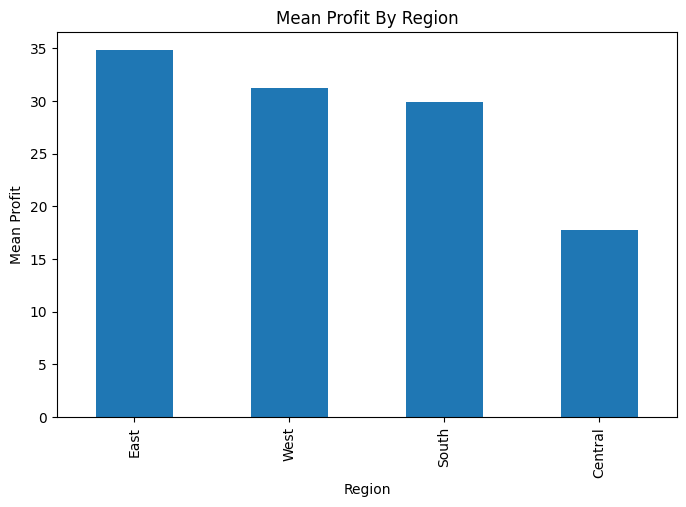

In [223]:
plt.figure(8, figsize=(8,5))
dfByRegion['Profit'].mean().sort_values(ascending=False).plot(kind='bar');
plt.ylabel('Mean Profit');
plt.title('Mean Profit By Region');

**How do the Profit in different Segments compare in different Regions?**

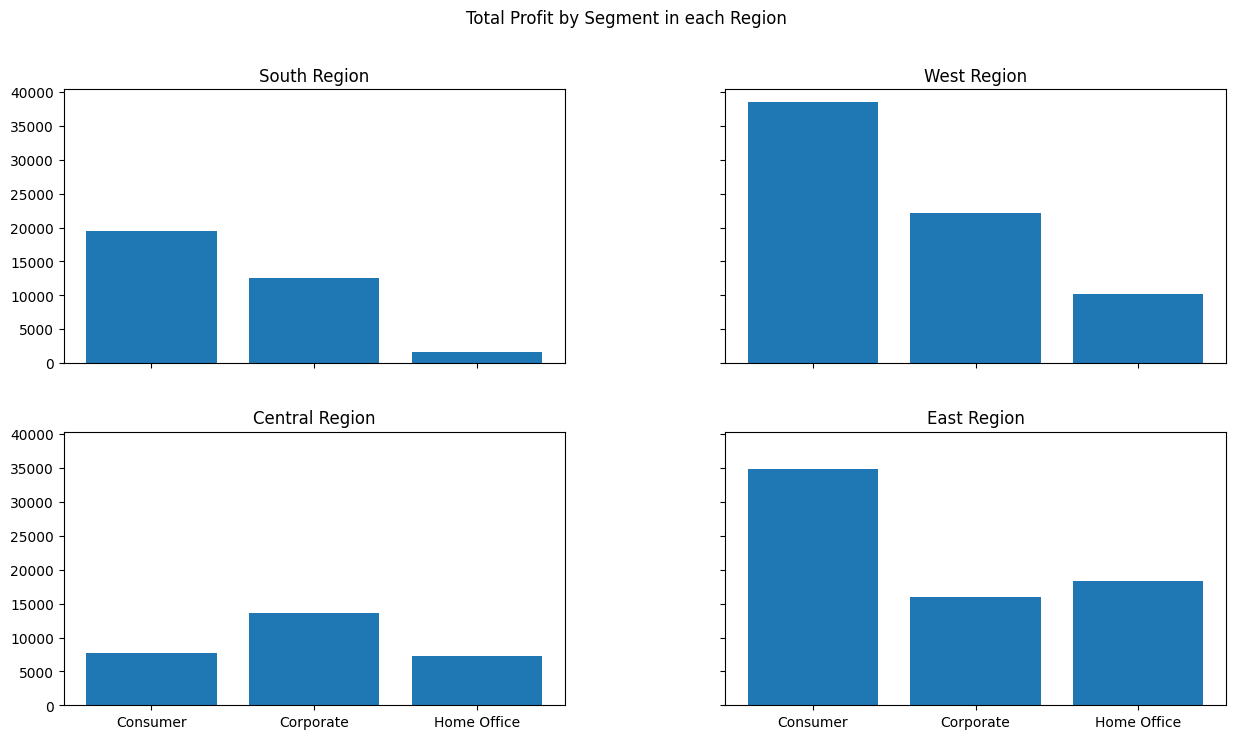

In [224]:
dfByRegionSegment = raw_train.groupby(['Region', 'Segment'])

fig, axs = plt.subplots(2,2, sharey=True, sharex=True, figsize=(15,8))
axsIdx = [[0,0], [0,1], [1,0], [1,1]]
plt.subplots_adjust(wspace=0.32,hspace=0.25);

for idx, region in enumerate(regions):
    data = dfByRegionSegment['Profit'].sum()[region]
    axs[axsIdx[idx][0],axsIdx[idx][1]].bar(data.index, data.values)
    axs[axsIdx[idx][0],axsIdx[idx][1]].title.set_text(f"{region} Region")

plt.suptitle("Total Profit by Segment in each Region")
plt.show()

**What is the Mean Profit for different Segments in different Regions?**

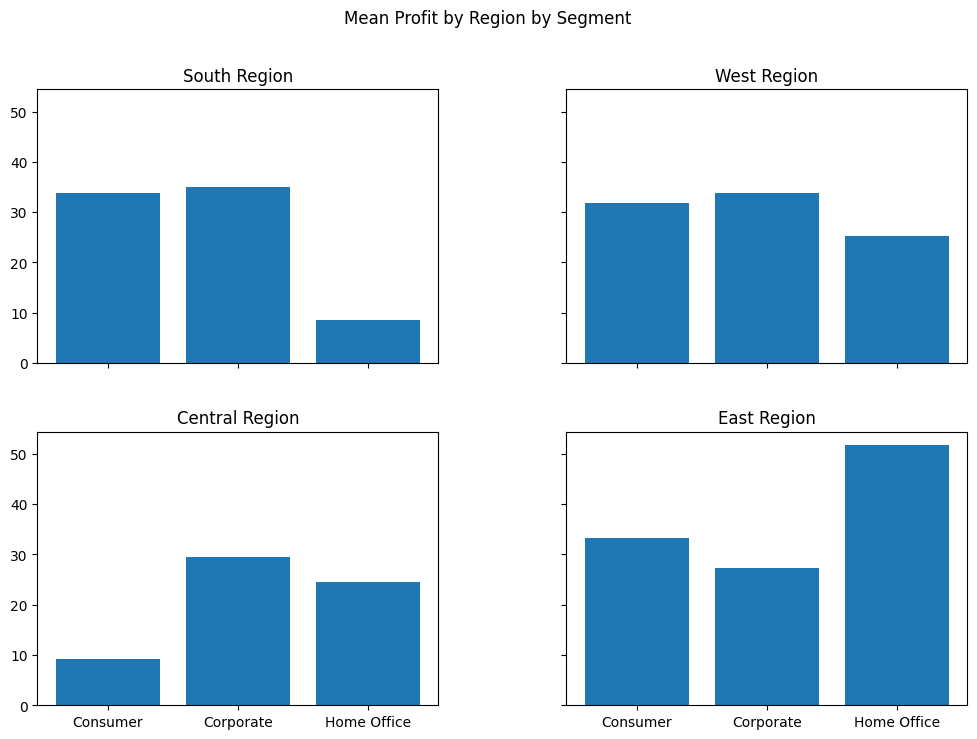

In [225]:
fig, axs = plt.subplots(2,2, sharey=True, sharex=True, figsize=(12,8))
axsIdx = [[0,0], [0,1], [1,0], [1,1]]
plt.subplots_adjust(wspace=0.32,hspace=0.25);

for idx, region in enumerate(regions):
    data = dfByRegionSegment['Profit'].mean()[region]
    axs[axsIdx[idx][0],axsIdx[idx][1]].bar(data.index, data.values)
    axs[axsIdx[idx][0],axsIdx[idx][1]].title.set_text(f"{region} Region")

plt.suptitle("Mean Profit by Region by Segment")
plt.show()

#Missing Value Imputation

In [226]:
raw_train.isnull().sum()

,0
Order Date,0
order_month_year,0
order_day,0
order_month,0
order_year,0
ship_day,0
ship_month,0
ship_year,0
Ship Date,0
Ship Mode,0


**Now In this case we dont have any missing or null value but if there we would handle it by following**
*   For numerical variables: imputation using mean or median.
*   For categorical variables: imputation using mode.



#Outlier Treatment

**we are going to see outliers for sales, Quantity, Discount, Profit**

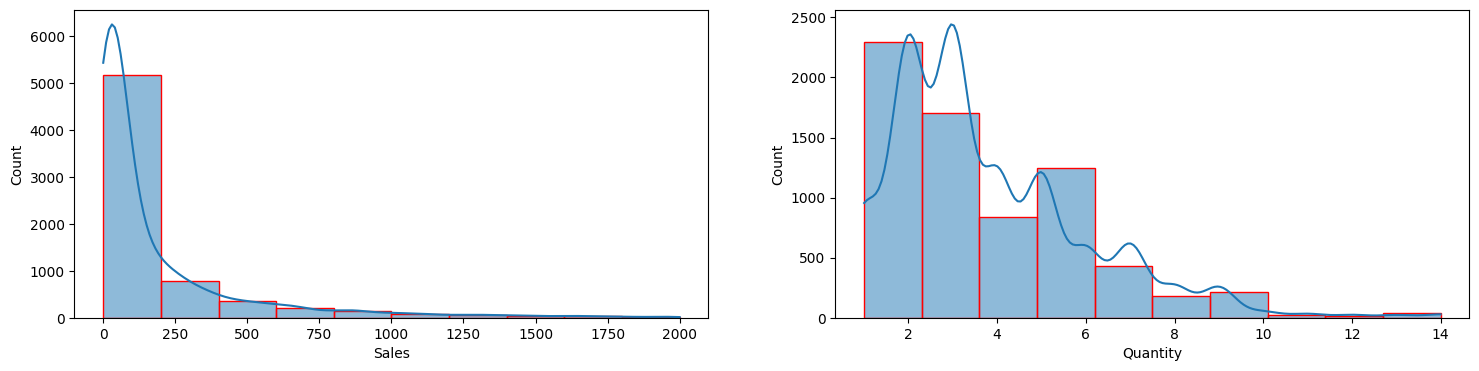

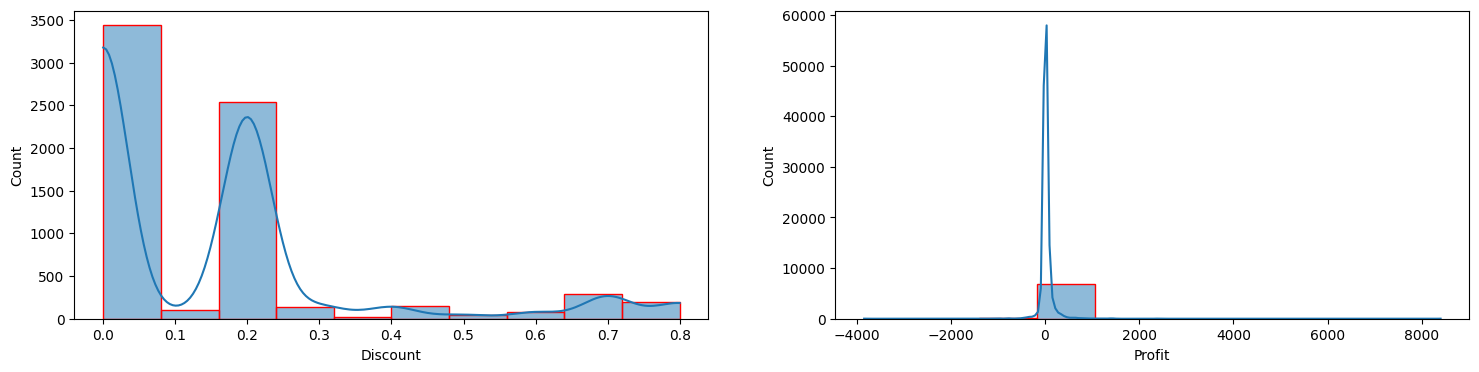

In [227]:
plt.figure(10, figsize=(18, 4))
plt.subplots_adjust(wspace=0.2)
sns.histplot(data=raw_train[raw_train['Sales'] <= 2000], x='Sales', ax=plt.subplot(121), bins=10, kde=True, edgecolor='red');
sns.histplot(data=raw_train, x='Quantity', ax=plt.subplot(122), bins=10, kde=True, edgecolor='red');

plt.figure(11, figsize=(18, 4))
plt.subplots_adjust(wspace=0.2)
sns.histplot(data=raw_train, x='Discount', ax=plt.subplot(121), bins=10, kde=True, edgecolor='red');
sns.histplot(data=raw_train, x='Profit', ax=plt.subplot(122), bins=10, kde=True, edgecolor='red');

In [228]:
def data_transform(dataFrame):
    posData = dataFrame[dataFrame > 0]
    bcData, lam = stats.boxcox(posData)
    dataFrame[dataFrame > 0] = bcData
    dataFrame[dataFrame <= 0] = -1/lam
    return dataFrame

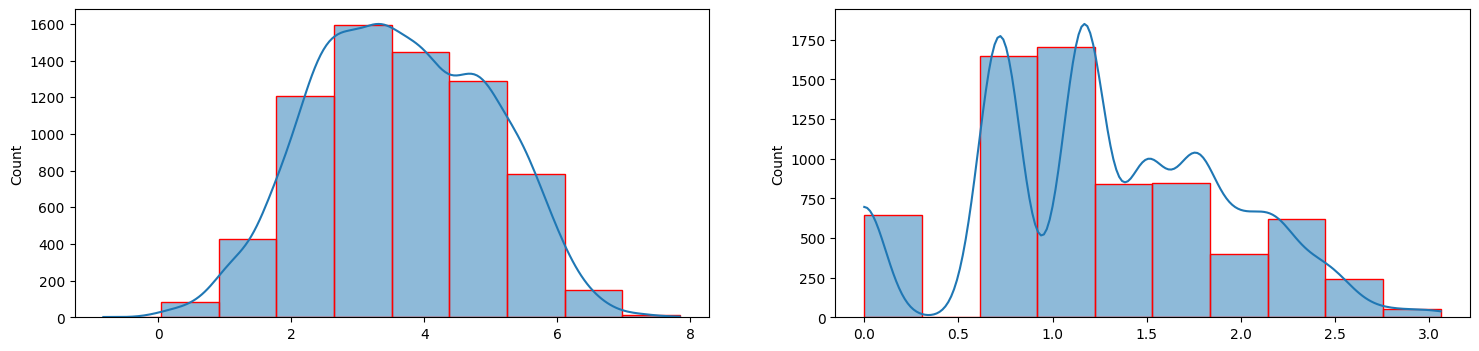

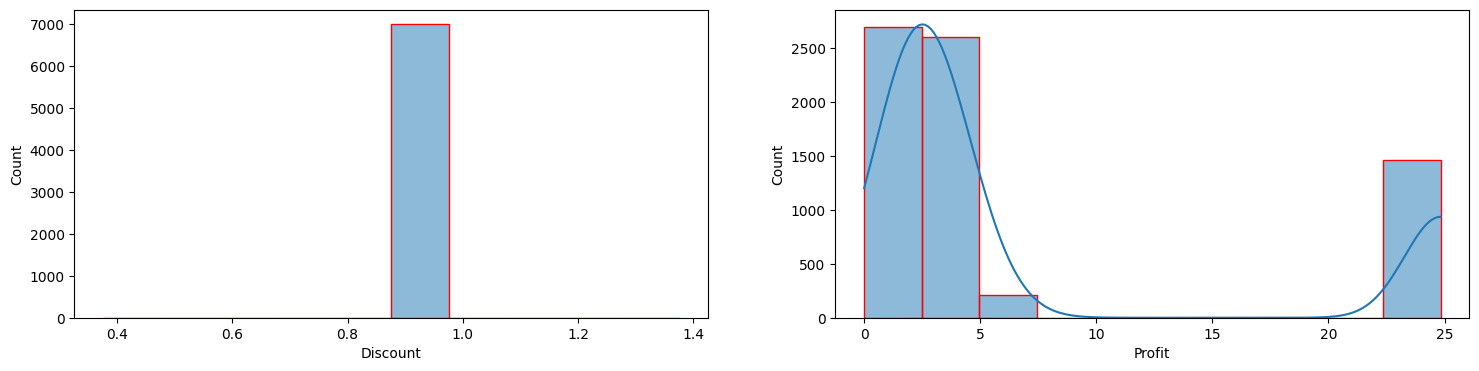

In [229]:
plt.figure(13, figsize=(18, 4))
plt.subplots_adjust(wspace=0.2)
sns.histplot(data=stats.boxcox(raw_train['Sales'])[0], ax=plt.subplot(121),bins=10, kde=True, edgecolor='red');
sns.histplot(data=stats.boxcox(raw_train['Quantity'])[0], ax=plt.subplot(122), bins=10, kde=True, edgecolor='red');

plt.figure(14, figsize=(18, 4))
plt.subplots_adjust(wspace=0.2)
sns.histplot(data=data_transform(raw_train['Discount'].copy()), ax=plt.subplot(121), bins=10, kde=True, edgecolor='red');
sns.histplot(data=data_transform(raw_train['Profit'].copy()), ax=plt.subplot(122), bins=10, kde=True, edgecolor='red');

#Model Building

In [230]:
#importing label encoder
from sklearn.preprocessing import LabelEncoder
#dropping the columns which is not necessary for model
X = raw_train.drop(['Order Date', 'order_month_year', 'Ship Date', 'ship_month_year', 'Sales'], axis=1)
for column in X.columns:
  if X[column].dtype == 'object':
    label = LabelEncoder()
    X[column] = label.fit_transform(X[column])
y = raw_train.Sales

In [231]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
#creating empty dictionary for the Root Mean Square Error and R2
models_results_rmse = {}
models_results_R2 = {}

def evaluate(y_t, y_p, title):
  table = PrettyTable()
  table.field_names = ['Metric', 'Value'] #it means Table should have two columns namely Metric and Value
  rmse = mean_squared_error(y_t, y_p) #[Tells the function to return RMSE instead of MSE. Without this, you'd get MSE by default],	[Rounds the result to 4 decimal places].
  r2 = r2_score(y_t, y_p)

  #adding rows to the pretty table
  table.add_row(['RMSE',rmse])
  table.add_row(['R2 Score',r2])

  #storing performance on the rmse and r2 dictionaries
  models_results_rmse[title] = rmse
  models_results_R2[title] = r2

  print(table)

def plot_forecasted_sales(y_pred, y_train, y_true=[], period=5, title=''):
  #let's plot
  plt.figure(figsize=(20,8))
  plt.plot(y_train.tolist(), color=colors[0])
  plt.plot([None for i in y_train] + [x for x in y_pred], color= colors[2])

  if len(y_true) > 0:
        plt.plot([None for i in y_train] + [x for x in y_true], color=colors[1])
        plt.legend(['2014-2016 Acual SALES', '2017 Acual SALES', f'2017 Forecasted SALES \(RMSE = {mean_squared_error(y_true, y_pred, squared=False).round(1)}, R2 = {r2_score(y_true, y_pred).round(3)})'])
  else:
      plt.legend(['2014-2017 Actual SALES', '2018-2020 Forecasted SALES'])

 # set parameters
  plt.xticks(range(0, len(y_train) + len(y_pred), period), rotation=75)
  plt.xlabel('Week')
  plt.ylabel('Sales')
  plt.title(title)
  plt.show()

**Lets split the data and apply Linear Regression**

In [232]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#creating object for linear regression
modelLR = LinearRegression()
modelLR.fit(x_train, y_train)
y_pred = modelLR.predict(x_test) #now model will predict the values for the given x_test dataset
evaluate(y_test, y_pred, title='Linear Regression') #we are passing the y_pred means values predicted by the model and the actual values i.e y_test and we will evaluate the model performance




+----------+--------------------+
|  Metric  |       Value        |
+----------+--------------------+
|   RMSE   | 181137.3642789412  |
| R2 Score | 0.4972012199508107 |
+----------+--------------------+


**Building Decision tree regressor**

In [233]:
#importing libraries
from sklearn.tree import DecisionTreeRegressor

#building model
modelDT = DecisionTreeRegressor(max_depth=3)

#training the model
modelDT.fit(x_train,y_train)

#predicting on new data
y_pred = modelDT.predict(x_test)

#evaluating models performance
evaluate(y_test, y_pred, title='Decision Regression')

+----------+--------------------+
|  Metric  |       Value        |
+----------+--------------------+
|   RMSE   | 103806.21510279935 |
| R2 Score | 0.7118560352085281 |
+----------+--------------------+


**RandomForest model**

In [234]:
#importing library for random forest
from sklearn.ensemble import RandomForestRegressor

#creating the object
modelRFR = RandomForestRegressor(max_depth=10)
#training the model
modelRFR.fit(x_train, y_train)

y_pred = modelRFR.predict(x_test)

#lets evaluate the performance
evaluate(y_test, y_pred, title='Random Forest Regressor')

+----------+--------------------+
|  Metric  |       Value        |
+----------+--------------------+
|   RMSE   | 51966.66960623096  |
| R2 Score | 0.8557515828650605 |
+----------+--------------------+


**Support Vector Machine**

In [235]:
#importing library
from sklearn.svm import SVR

#creating object
modelSVR = SVR()

#building model
modelSVR.fit(x_train, y_train)
y_pred = modelSVR.predict(x_test)

#evaluate the performance the model
evaluate(y_test, y_pred, title='Support Vector Machine')


+----------+----------------------+
|  Metric  |        Value         |
+----------+----------------------+
|   RMSE   |  387107.1283129601   |
| R2 Score | -0.07452701787341609 |
+----------+----------------------+


**XGBoost**

In [236]:
#importing libraries
from xgboost import XGBRegressor

#creating object
modelXGB = XGBRegressor()
modelXGB.fit(x_train, y_train)
pred = modelXGB.predict(x_test)

evaluate(y_test, pred, title='XGBRegressor')

+----------+--------------------+
|  Metric  |       Value        |
+----------+--------------------+
|   RMSE   | 58977.86965164249  |
| R2 Score | 0.8362899834123649 |
+----------+--------------------+


#Model Evaluation

### **Model Evaluation By R2 Score**

Text(0.5, 0, 'R2 Score')

<Figure size 1800x800 with 0 Axes>

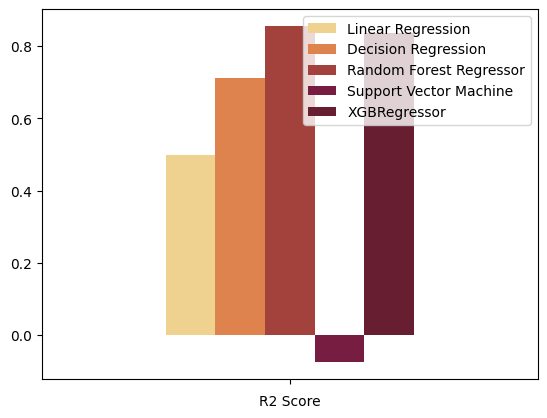

In [237]:
plt.figure(figsize=(18,8))
pd.DataFrame(models_results_R2, index=['']).plot.bar(color=colors2); #index=[''] delete the first row and name the models columnwise
plt.xlabel('R2 Score')

### **Model Evaluation By Root Mean Square Error**

<Figure size 1800x800 with 0 Axes>

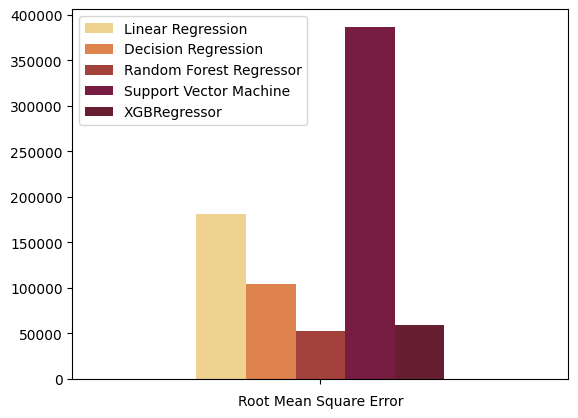

In [238]:
plt.figure(figsize=(18,8))
pd.DataFrame(models_results_rmse, index=['']).plot.bar(color=colors2);
plt.xlabel('Root Mean Square Error');

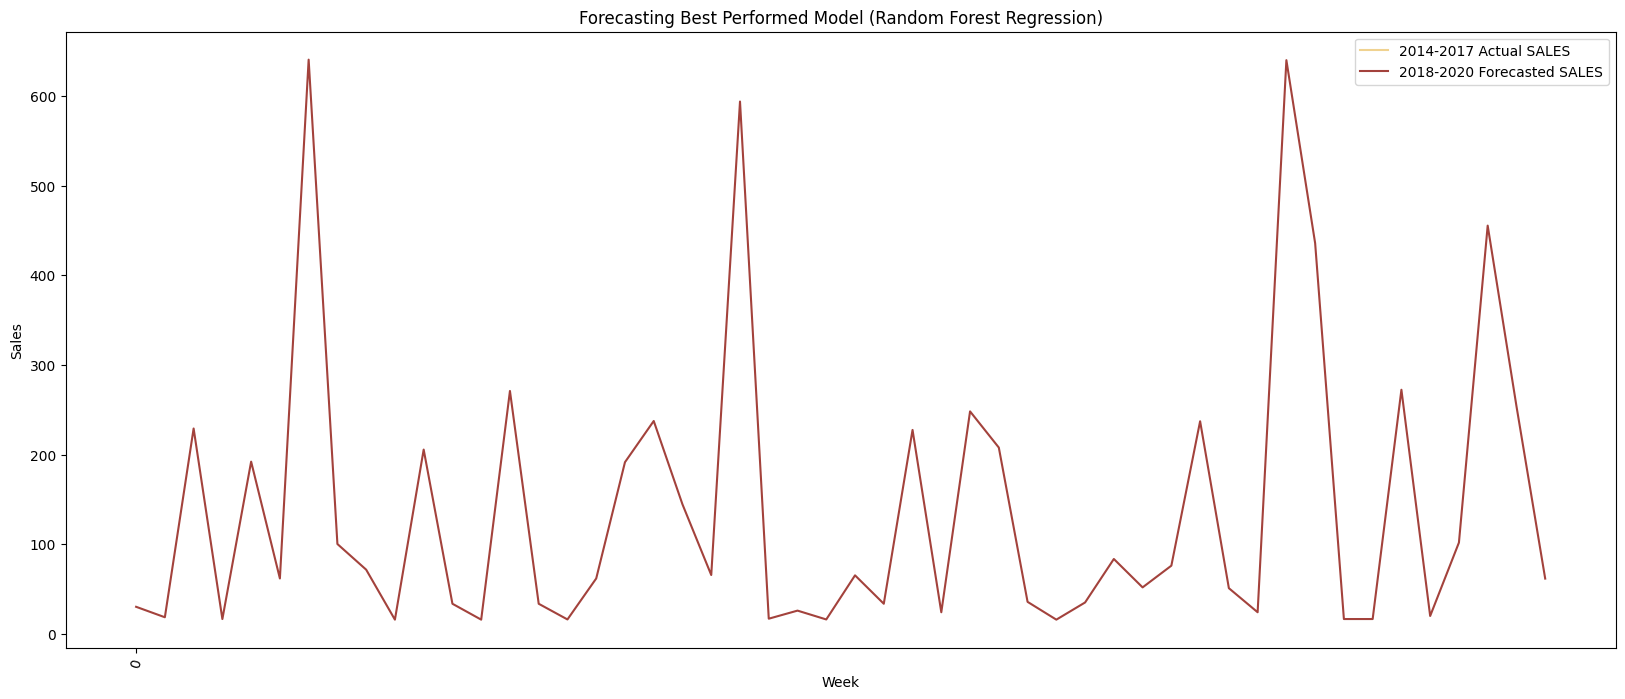

In [239]:
X = raw_test.drop(['Order Date', 'order_month_year', 'Ship Date', 'ship_month_year'], axis=1)
for col in X.columns:
    if X[col].dtype == 'object':
        lb = LabelEncoder() # Shift + Tab
        X[col] = lb.fit_transform(X[col])

days = 50
y_pred = modelRFR.predict(X)[:days] #it slices the first 50 predictions from X
y_test = data.iloc[6994:6994+days].values
plot_forecasted_sales(y_train=y_test, y_pred=y_pred, period=days, title='Forecasting Best Performed Model (Random Forest Regression)')